In [1]:
import os
import sys
import gc
import pickle
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
from typing import *
from tqdm.notebook import tqdm
from pathlib import Path
from matplotlib import pyplot as plt

pd.set_option('max_columns', 50)
pd.set_option('max_rows', 200)
warnings.simplefilter('ignore')
sns.set()

In [2]:
base_dir = Path().resolve()
sys.path.append(str(base_dir / '../'))

from utils.preprocess import *
from utils.model import *
from utils.train import *
from utils.eval import *
from utils.detectron2helper import *

fail to import apex_C: apex was not installed or installed without --cpp_ext.
fail to import amp_C: apex was not installed or installed without --cpp_ext.
** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



HACKING: overriding COCOeval.summarize = vin_summarize...


In [3]:
def seed_everything(seed: int, device: str):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    with torch.cuda.device(device):
        torch.cuda.empty_cache()

In [4]:
from dataclasses import dataclass, field, asdict
import yaml


@dataclass
class Config:
    # General
    debug: bool = False
    outdir: str = "detectron2_results/results02"
    device: str = "cuda:2"
    device_id: int = 2
    num_workers: int = 8

    # Data config
    imgconf_file: str = '../../data/VinBigData/train.csv'
    meta_file: str = '../../data/VinBigData/train_meta.csv'
    test_meta_file: str = '../../data/VinBigData/test_meta.csv'
    imgdir_name: str = "../../data/VinBigData/png1024"
    img_size: int = 1024
    seed: int = 111
    n_splits: int = 5
    iou_thr: float = 0.5
    skip_box_thr: float = 0.0001
    rm: bool = False
    
    model_config: str = 'COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml'
    
    # Training config
    batch_size: int = 2
    iter: int = 10000
    lr_scheduler_name: str = "WarmupCosineLR"  # WarmupMultiStepLR (default) or WarmupCosineLR
    base_lr: float = 0.00025
    roi_batch_size_per_image: int = 512
    eval_period: int = 10000
    checkpoint_period: int = 10000
        
    aug_kwargs: Dict = field(default_factory=lambda: {})
        

    def update(self, param_dict: Dict) -> "Config":
        # Overwrite by `param_dict`
        for key, value in param_dict.items():
            if not hasattr(self, key):
                raise ValueError(f"[ERROR] Unexpected key for flag = {key}")
            setattr(self, key, value)
        return self
    
    def to_yaml(self, filepath: str, width: int = 120):
        with open(filepath, 'w') as f:
            yaml.dump(asdict(self), f, width=width)

In [5]:
config_dict = {
    'debug': False,
    'batch_size': 8,
    'base_lr': 1e-4,
    'iou_thr': 0.5,
    'rm': True,
    'iter': 10000,
    'eval_period': 1000,
    'checkpoint_period': 1000,
    "aug_kwargs": {
        "HorizontalFlip": {"p": 0.5},
        "ShiftScaleRotate": {"scale_limit": 0.15, "rotate_limit": 10, "p": 0.5},
        "RandomBrightnessContrast": {"p": 0.5},
        "Blur": {"blur_limit": (3, 10), "p": 0.4},
        "IAAAffine": {"p": 0.5}
    },
}
config = Config().update(config_dict)
config.to_yaml(base_dir / config.outdir / 'config.yaml')

In [6]:
classes_nms = [
    "Aortic enlargement",
    "Atelectasis",
    "Calcification",
    "Cardiomegaly",
    "Consolidation",
    "ILD",
    "Infiltration",
    "Lung Opacity",
    "Nodule/Mass",
    "Other lesion",
    "Pleural effusion",
    "Pleural thickening",
    "Pneumothorax",
    "Pulmonary fibrosis",
#     "No Finding"
]
classes_dict = {index: class_name  for index, class_name in enumerate(classes_nms)}

In [7]:
import argparse
import dataclasses
import json
from dataclasses import dataclass
from distutils.util import strtobool
import cv2
import detectron2
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultPredictor, DefaultTrainer, launch
from detectron2.evaluation import COCOEvaluator
from detectron2.structures import BoxMode
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer
from detectron2.data.samplers.distributed_sampler import RepeatFactorTrainingSampler

setup_logger()

<Logger detectron2 (DEBUG)>

In [8]:
from scipy import stats
from scipy.stats.mstats import gmean


def get_repeat_factor(class_weights: List[float], dataset_dicts_fold: List[Dict[str, Any]]) -> torch.Tensor:
    repeat_factor = list()
    for dd in dataset_dicts_fold:
        weights = list()
        for annot in dd['annotations']:
            weights += [weight_by_folds[0][annot['category_id']]]
#         repeat_factor += [stats.hmean(weights)]
        repeat_factor += [stats.gmean(weights)]
#         repeat_factor += [np.mean(weights)]
    
    return torch.tensor(repeat_factor, dtype=torch.float32)

In [9]:
rm = '_rm' if config.rm else ''
train = pickle.load(open(str(base_dir / f'nms{config.iou_thr}_train_{config.img_size}{rm}.pkl'), 'rb'))
dataset_dicts = pickle.load(open(str(base_dir / f'nms{config.iou_thr}_dataset_dicts_{config.img_size}{rm}.pkl'), 'rb'))
mkf = pickle.load(open(str(base_dir / f'nms{config.iou_thr}_mkf_{config.img_size}{rm}.pkl'), 'rb'))

In [10]:
weight_by_folds = list()
for n_data_by_class in mkf.stats.values[:, 1:]:
    weight_by_folds += [(1 / n_data_by_class) / (1 / n_data_by_class).sum()]

In [11]:
from detectron2.config.config import CfgNode as CN


torch.cuda.set_device(config.device_id)

for fold, (train_df, valid_df) in enumerate(mkf):
    seed_everything(seed=config.seed, device=config.device)
    
    outdir = base_dir / config.outdir / f'fold-{fold + 1}'
    
    train_idx = list(pd.DataFrame({'image_id': [dd['image_id'] for dd in dataset_dicts]}).query(f"image_id in {train_df['image_id'].values.tolist()}").index)
    valid_idx = list(pd.DataFrame({'image_id': [dd['image_id'] for dd in dataset_dicts]}).query(f"image_id in {valid_df['image_id'].values.tolist()}").index)
        
    DatasetCatalog.register(
        f"vinbigdata_train_fold{fold + 1}",
        lambda: [dataset_dicts[i] for i in train_idx],
    )
    MetadataCatalog.get(f"vinbigdata_train_fold{fold + 1}").set(thing_classes=classes_nms)

    DatasetCatalog.register(
        f"vinbigdata_valid_fold{fold + 1}",
        lambda: [dataset_dicts[i] for i in valid_idx],
    )
    MetadataCatalog.get(f"vinbigdata_valid_fold{fold + 1}").set(thing_classes=classes_nms)
    
    cfg = get_cfg()
    cfg.aug_kwargs = CN(config.aug_kwargs)  # pass aug_kwargs to cfg

    original_output_dir = cfg.OUTPUT_DIR
    cfg.OUTPUT_DIR = str(outdir)
    print(f"cfg.OUTPUT_DIR {original_output_dir} -> {cfg.OUTPUT_DIR}")

    config_name = config.model_config
    cfg.merge_from_file(model_zoo.get_config_file(config_name))
    cfg.DATASETS.TRAIN = (f"vinbigdata_train_fold{fold + 1}",)
    cfg.DATASETS.TEST = (f"vinbigdata_valid_fold{fold + 1}",)
    cfg.TEST.EVAL_PERIOD = config.eval_period

    cfg.DATALOADER.NUM_WORKERS = config.num_workers
    # Let training initialize from model zoo
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_name)
    cfg.SOLVER.IMS_PER_BATCH = config.batch_size
    cfg.SOLVER.LR_SCHEDULER_NAME = config.lr_scheduler_name
    cfg.SOLVER.BASE_LR = config.base_lr  # pick a good LR
    cfg.SOLVER.MAX_ITER = config.iter
    cfg.SOLVER.CHECKPOINT_PERIOD = config.checkpoint_period  # Small value=Frequent save need a lot of storage.
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = config.roi_batch_size_per_image
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(classes_nms)
    # NOTE: this config means the number of classes,
    # but a few popular unofficial tutorials incorrect uses num_classes+1 here.

    cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[16], [32], [64], [128], [256], [512], [1024]]
    cfg.MODEL.RPN.IN_FEATURES = ['p2', 'p2', 'p3', 'p4', 'p5', 'p6', 'p6']
    cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [[0.33, 0.5, 1.0, 2.0, 3.0]]

    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    
    repeat_factors = get_repeat_factor(weight_by_folds[fold], [dataset_dicts[i] for i in train_idx])
    
    trainer = MyTrainer(cfg, RepeatFactorTrainingSampler(repeat_factors=repeat_factors, seed=config.seed))
    trainer.resume_or_load(resume=False)
    trainer.train()
    
    del trainer, cfg, train_idx, valid_idx
    gc.collect()

cfg.OUTPUT_DIR ./output -> /home/yamaguchi-milkcocholate/VinBigData/src/VinBigData-ObjectDetection/detectron2_results/results02/fold-1
[03/26 19:34:14 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7),

Skip loading parameter 'proposal_generator.anchor_generator.cell_anchors.0' to the model due to incompatible shapes: (3, 4) in the checkpoint but (5, 4) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.anchor_generator.cell_anchors.1' to the model due to incompatible shapes: (3, 4) in the checkpoint but (5, 4) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.anchor_generator.cell_anchors.2' to the model due to incompatible shapes: (3, 4) in the checkpoint but (5, 4) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.anchor_generator.cell_anchors.3' to the model due to incompatible shapes: (3, 4) in the checkpoint but (5, 4) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.anchor_generator.cell_anchors.4' to the model due to incompatible shapes: (3, 4) 

[03/26 19:34:15 d2.engine.train_loop]: Starting training from iteration 0
[03/26 19:34:47 d2.utils.events]:  eta: 4:22:46  iter: 19  total_loss: 2.581  loss_cls: 1.882  loss_box_reg: 0.0006733  loss_rpn_cls: 0.6395  loss_rpn_loc: 0.04986  time: 1.5809  data_time: 0.0440  lr: 1.9981e-06  max_mem: 12548M
[03/26 19:35:18 d2.utils.events]:  eta: 4:22:30  iter: 39  total_loss: 2.356  loss_cls: 1.667  loss_box_reg: 0.00067  loss_rpn_cls: 0.6309  loss_rpn_loc: 0.05139  time: 1.5808  data_time: 0.0247  lr: 3.996e-06  max_mem: 12548M
[03/26 19:35:50 d2.utils.events]:  eta: 4:22:09  iter: 59  total_loss: 1.93  loss_cls: 1.231  loss_box_reg: 0.001118  loss_rpn_cls: 0.6118  loss_rpn_loc: 0.05315  time: 1.5820  data_time: 0.0246  lr: 5.9936e-06  max_mem: 12548M
[03/26 19:36:22 d2.utils.events]:  eta: 4:21:51  iter: 79  total_loss: 1.447  loss_cls: 0.8145  loss_box_reg: 0.001767  loss_rpn_cls: 0.5775  loss_rpn_loc: 0.05864  time: 1.5833  data_time: 0.0238  lr: 7.9909e-06  max_mem: 12548M
[03/26 19:3

Skip loading parameter 'proposal_generator.anchor_generator.cell_anchors.0' to the model due to incompatible shapes: (3, 4) in the checkpoint but (5, 4) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.anchor_generator.cell_anchors.1' to the model due to incompatible shapes: (3, 4) in the checkpoint but (5, 4) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.anchor_generator.cell_anchors.2' to the model due to incompatible shapes: (3, 4) in the checkpoint but (5, 4) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.anchor_generator.cell_anchors.3' to the model due to incompatible shapes: (3, 4) in the checkpoint but (5, 4) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.anchor_generator.cell_anchors.4' to the model due to incompatible shapes: (3, 4) 

[03/27 00:33:26 d2.engine.train_loop]: Starting training from iteration 0
[03/27 00:33:58 d2.utils.events]:  eta: 4:22:32  iter: 19  total_loss: 2.591  loss_cls: 1.897  loss_box_reg: 0.0007151  loss_rpn_cls: 0.6388  loss_rpn_loc: 0.05518  time: 1.5787  data_time: 0.0439  lr: 1.9981e-06  max_mem: 12548M
[03/27 00:34:29 d2.utils.events]:  eta: 4:22:09  iter: 39  total_loss: 2.369  loss_cls: 1.679  loss_box_reg: 0.000758  loss_rpn_cls: 0.6308  loss_rpn_loc: 0.05746  time: 1.5795  data_time: 0.0251  lr: 3.996e-06  max_mem: 12548M
[03/27 00:35:01 d2.utils.events]:  eta: 4:21:43  iter: 59  total_loss: 1.883  loss_cls: 1.234  loss_box_reg: 0.0009634  loss_rpn_cls: 0.6092  loss_rpn_loc: 0.05647  time: 1.5800  data_time: 0.0261  lr: 5.9936e-06  max_mem: 12548M
[03/27 00:35:33 d2.utils.events]:  eta: 4:21:25  iter: 79  total_loss: 1.452  loss_cls: 0.7987  loss_box_reg: 0.005069  loss_rpn_cls: 0.5787  loss_rpn_loc: 0.05635  time: 1.5813  data_time: 0.0257  lr: 7.9909e-06  max_mem: 12548M
[03/27 0

Skip loading parameter 'proposal_generator.anchor_generator.cell_anchors.0' to the model due to incompatible shapes: (3, 4) in the checkpoint but (5, 4) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.anchor_generator.cell_anchors.1' to the model due to incompatible shapes: (3, 4) in the checkpoint but (5, 4) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.anchor_generator.cell_anchors.2' to the model due to incompatible shapes: (3, 4) in the checkpoint but (5, 4) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.anchor_generator.cell_anchors.3' to the model due to incompatible shapes: (3, 4) in the checkpoint but (5, 4) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.anchor_generator.cell_anchors.4' to the model due to incompatible shapes: (3, 4) 

[03/27 05:31:13 d2.engine.train_loop]: Starting training from iteration 0
[03/27 05:31:44 d2.utils.events]:  eta: 4:22:47  iter: 19  total_loss: 2.588  loss_cls: 1.9  loss_box_reg: 0.0006792  loss_rpn_cls: 0.6404  loss_rpn_loc: 0.05026  time: 1.5804  data_time: 0.0473  lr: 1.9981e-06  max_mem: 12548M
[03/27 05:32:16 d2.utils.events]:  eta: 4:22:23  iter: 39  total_loss: 2.353  loss_cls: 1.668  loss_box_reg: 0.0007318  loss_rpn_cls: 0.6321  loss_rpn_loc: 0.06045  time: 1.5814  data_time: 0.0254  lr: 3.996e-06  max_mem: 12548M
[03/27 05:32:48 d2.utils.events]:  eta: 4:21:52  iter: 59  total_loss: 1.922  loss_cls: 1.225  loss_box_reg: 0.001417  loss_rpn_cls: 0.6124  loss_rpn_loc: 0.0498  time: 1.5813  data_time: 0.0244  lr: 5.9936e-06  max_mem: 12548M
[03/27 05:33:19 d2.utils.events]:  eta: 4:21:32  iter: 79  total_loss: 1.428  loss_cls: 0.7899  loss_box_reg: 0.003289  loss_rpn_cls: 0.5772  loss_rpn_loc: 0.05705  time: 1.5822  data_time: 0.0251  lr: 7.9909e-06  max_mem: 12548M
[03/27 05:3

Skip loading parameter 'proposal_generator.anchor_generator.cell_anchors.0' to the model due to incompatible shapes: (3, 4) in the checkpoint but (5, 4) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.anchor_generator.cell_anchors.1' to the model due to incompatible shapes: (3, 4) in the checkpoint but (5, 4) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.anchor_generator.cell_anchors.2' to the model due to incompatible shapes: (3, 4) in the checkpoint but (5, 4) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.anchor_generator.cell_anchors.3' to the model due to incompatible shapes: (3, 4) in the checkpoint but (5, 4) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.anchor_generator.cell_anchors.4' to the model due to incompatible shapes: (3, 4) 

[03/27 10:29:51 d2.engine.train_loop]: Starting training from iteration 0
[03/27 10:30:23 d2.utils.events]:  eta: 4:22:59  iter: 19  total_loss: 2.581  loss_cls: 1.89  loss_box_reg: 0.0007701  loss_rpn_cls: 0.6413  loss_rpn_loc: 0.0514  time: 1.5815  data_time: 0.0466  lr: 1.9981e-06  max_mem: 12548M
[03/27 10:30:54 d2.utils.events]:  eta: 4:22:29  iter: 39  total_loss: 2.347  loss_cls: 1.678  loss_box_reg: 0.0008543  loss_rpn_cls: 0.6323  loss_rpn_loc: 0.0583  time: 1.5813  data_time: 0.0247  lr: 3.996e-06  max_mem: 12548M
[03/27 10:31:26 d2.utils.events]:  eta: 4:21:56  iter: 59  total_loss: 1.88  loss_cls: 1.23  loss_box_reg: 0.0007064  loss_rpn_cls: 0.6073  loss_rpn_loc: 0.04999  time: 1.5811  data_time: 0.0252  lr: 5.9936e-06  max_mem: 12548M
[03/27 10:31:58 d2.utils.events]:  eta: 4:21:34  iter: 79  total_loss: 1.445  loss_cls: 0.8077  loss_box_reg: 0.004602  loss_rpn_cls: 0.5761  loss_rpn_loc: 0.05452  time: 1.5822  data_time: 0.0255  lr: 7.9909e-06  max_mem: 12548M
[03/27 10:32

Skip loading parameter 'proposal_generator.anchor_generator.cell_anchors.0' to the model due to incompatible shapes: (3, 4) in the checkpoint but (5, 4) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.anchor_generator.cell_anchors.1' to the model due to incompatible shapes: (3, 4) in the checkpoint but (5, 4) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.anchor_generator.cell_anchors.2' to the model due to incompatible shapes: (3, 4) in the checkpoint but (5, 4) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.anchor_generator.cell_anchors.3' to the model due to incompatible shapes: (3, 4) in the checkpoint but (5, 4) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.anchor_generator.cell_anchors.4' to the model due to incompatible shapes: (3, 4) 

[03/27 15:27:20 d2.engine.train_loop]: Starting training from iteration 0
[03/27 15:27:52 d2.utils.events]:  eta: 4:22:30  iter: 19  total_loss: 2.572  loss_cls: 1.882  loss_box_reg: 0.0007095  loss_rpn_cls: 0.6405  loss_rpn_loc: 0.04634  time: 1.5773  data_time: 0.0465  lr: 1.9981e-06  max_mem: 12548M
[03/27 15:28:24 d2.utils.events]:  eta: 4:22:07  iter: 39  total_loss: 2.351  loss_cls: 1.66  loss_box_reg: 0.0007343  loss_rpn_cls: 0.6298  loss_rpn_loc: 0.05232  time: 1.5787  data_time: 0.0230  lr: 3.996e-06  max_mem: 12548M
[03/27 15:28:55 d2.utils.events]:  eta: 4:21:39  iter: 59  total_loss: 1.9  loss_cls: 1.242  loss_box_reg: 0.001332  loss_rpn_cls: 0.6095  loss_rpn_loc: 0.05253  time: 1.5793  data_time: 0.0220  lr: 5.9936e-06  max_mem: 12548M
[03/27 15:29:27 d2.utils.events]:  eta: 4:21:13  iter: 79  total_loss: 1.455  loss_cls: 0.8179  loss_box_reg: 0.004083  loss_rpn_cls: 0.5799  loss_rpn_loc: 0.05544  time: 1.5804  data_time: 0.0237  lr: 7.9909e-06  max_mem: 12548M
[03/27 15:2

## Inference

In [18]:
_, valid_df = mkf[0]
valid_idx = list(pd.DataFrame({'image_id': [dd['image_id'] for dd in dataset_dicts]}).query(f"image_id in {valid_df['image_id'].values.tolist()}").index)

In [27]:
cfg = get_cfg()
cfg.aug_kwargs = CN(config.aug_kwargs)  # pass aug_kwargs to cfg

original_output_dir = cfg.OUTPUT_DIR
cfg.OUTPUT_DIR = str(outdir)
print(f"cfg.OUTPUT_DIR {original_output_dir} -> {cfg.OUTPUT_DIR}")

config_name = config.model_config
cfg.merge_from_file(model_zoo.get_config_file(config_name))
cfg.DATASETS.TRAIN = (f"vinbigdata_train_fold{fold + 1}",)
cfg.DATASETS.TEST = (f"vinbigdata_valid_fold{fold + 1}",)
cfg.TEST.EVAL_PERIOD = config.eval_period

cfg.DATALOADER.NUM_WORKERS = config.num_workers

cfg.MODEL.WEIGHTS = str(base_dir / config.outdir / 'fold-1' /"model_final.pth")
cfg.SOLVER.IMS_PER_BATCH = config.batch_size
cfg.SOLVER.LR_SCHEDULER_NAME = config.lr_scheduler_name
cfg.SOLVER.BASE_LR = config.base_lr  # pick a good LR
cfg.SOLVER.MAX_ITER = config.iter
cfg.SOLVER.CHECKPOINT_PERIOD = config.checkpoint_period  # Small value=Frequent save need a lot of storage.
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = config.roi_batch_size_per_image
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(classes_nms)

print("Original thresh", cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST)  # 0.05
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0. # set a custom testing threshold
print("Changed  thresh", cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST)
predictor = DefaultPredictor(cfg)

Loading config /home/yamaguchi-milkcocholate/.pyenv/versions/3.7.6/envs/VinBigData/lib/python3.7/site-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


cfg.OUTPUT_DIR ./output -> /home/yamaguchi-milkcocholate/VinBigData/src/VinBigData-ObjectDetection/detectron2_results/results00/fold-1
Original thresh 0.05
Changed  thresh 0.0


In [20]:
dataset_dicts_valid = [dataset_dicts[i] for i in valid_idx]
cols = ['x_min', 'y_min', 'x_max', 'y_max']
train_ = train.drop(columns=['x_min', 'y_min', 'x_max', 'y_max']).rename(columns={f'{c}_{config.img_size}': c for c in cols})
valid_evaluator = VinBigDataEval(train_.query(f"image_id in {[dd['image_id'] for dd in dataset_dicts_valid]}"))

Generating image data...
Generating category data...
Generating annotation data...


In [28]:
records = {'image_id': list(), 'PredictionString': list()}

for i in tqdm(range(ceil(len(dataset_dicts_valid) / config.batch_size))):
    inds = list(range(config.batch_size * i, min(config.batch_size * (i + 1), len(dataset_dicts_valid))))
    dataset_dicts_test_batch = [dataset_dicts_valid[i] for i in inds]
    im_list = [cv2.imread(d["file_name"]) for d in dataset_dicts_test_batch]
    outputs_list = predict_batch(predictor, im_list)
    
    for outputs, dd in zip(outputs_list, dataset_dicts_test_batch):
        instances = outputs["instances"]
        fields: Dict[str, Any] = instances.get_fields()
        pred_classes = fields["pred_classes"].cpu().numpy()
        pred_scores = fields["scores"].cpu().numpy()
        pred_boxes = fields["pred_boxes"].tensor.cpu().numpy()
        
        records['image_id'] += [dd['image_id']]
        records['PredictionString'] += [format_pred(pred_classes, pred_boxes, pred_scores)]
    
pred_valid_df = pd.DataFrame(records)

  0%|          | 0/441 [00:00<?, ?it/s]

In [38]:
def remove_lowscore(pred_df: pd.DataFrame, threshes: List[float]):
    assert len(classes_nms) == len(threshes)
    pred_df_ = pred_df.copy()
    
    for i in pred_df_.index:
        pred_str = list()
        for obj in np.array(pred_df_.loc[i, 'PredictionString'].split(' ')).reshape(-1, 6):
            try:
                thresh = threshes[int(obj[0])]
            except IndexError as e:
                continue
            
            if float(obj[1]) > thresh:
                pred_str += obj.tolist()
                
        pred_df_.loc[i, 'PredictionString'] = ' '.join(pred_str)
    
    return pred_df_

In [68]:
def evaluate_mAP(valid_pred_df: pd.DataFrame):
    mAPs = dict()
    for cls_id, cls_nm in tqdm(classes_dict.items()):
        results = valid_evaluator.evaluate(valid_pred_df, category_ids=[cls_id])
        mAPs[cls_nm] = results.stats[0]

    results = valid_evaluator.evaluate(valid_pred_df)
    mAPs['all'] = results.stats[0]
    
    return mAPs

In [69]:
mAPs = evaluate_mAP(pred_valid_df)

  0%|          | 0/14 [00:00<?, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.23s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.772
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.772
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.929
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.798
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.426
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.968
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.968
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

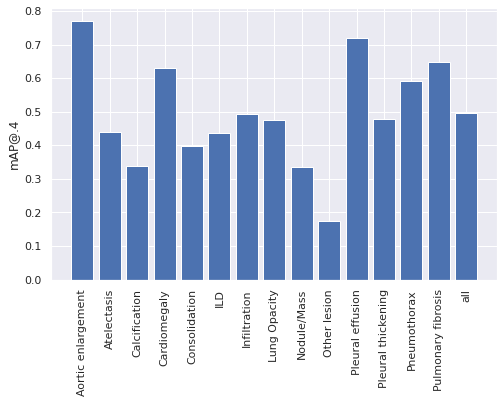

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.bar(mAPs.keys(), mAPs.values())
ax.set_ylabel('mAP@.4')
plt.xticks(rotation=90)
plt.show()

In [81]:
mAPs

{'Aortic enlargement': 0.7715037188921522,
 'Atelectasis': 0.4389502918479661,
 'Calcification': 0.3369935103449311,
 'Cardiomegaly': 0.6319310959043464,
 'Consolidation': 0.3990124238375785,
 'ILD': 0.43786637046397914,
 'Infiltration': 0.4922277102359513,
 'Lung Opacity': 0.47691001852315223,
 'Nodule/Mass': 0.3352686031942788,
 'Other lesion': 0.17439454047770703,
 'Pleural effusion': 0.7205817883627935,
 'Pleural thickening': 0.47808137402204964,
 'Pneumothorax': 0.5919994527015022,
 'Pulmonary fibrosis': 0.6485216942912988,
 'all': 0.49530304236426337}

In [65]:
records = {'image_id': valid_pred_df['image_id'].values.tolist(), 'PredictionString': list()}

for dd, pred_str in zip(dataset_dicts_valid, valid_pred_df.values[:, 1]):
    objs = np.array(pred_str.split(' ')).reshape((-1, 6))
    
    boxes, scores, labels = list(), list(), list()
    for obj in objs:
        boxes += [[
            int(obj[2]) / config.img_size,
            int(obj[3]) / config.img_size,
            int(obj[4]) / config.img_size,
            int(obj[5]) / config.img_size,
        ]]
        labels += [int(obj[0])]
        scores += [float(obj[1])]
    
    boxes, scores, labels = weighted_boxes_fusion([boxes], [scores], [labels], weights=None, iou_thr=config.iou_thr, skip_box_thr=config.skip_box_thr)
    boxes *= config.img_size
    records['PredictionString'] += [format_pred(labels, boxes, scores)]
    
valid_pred_df_wbf = pd.DataFrame(records)

In [67]:
mAPs_wbf = evaluate_mAP(valid_pred_df_wbf)

  0%|          | 0/14 [00:00<?, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.21s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.750
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.750
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.922
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.774
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.426
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.943
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.943
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s